In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

In [3]:
dataset_path = '.\data\ptsd'
train_path = os.path.join(dataset_path,'PTSD_Recognition','train')

In [4]:
classes = {
            0:'Compulsory Keep BothSide',
            1:'Compulsory Keep Left', 
            2:'Compulsory Keep Right', 
            3:'Cycle crossing', 
            4:'Danger', 
            5:'Give Way', 
            6:'Hump', 
            7:'Left Bend', 
            8:'Left Margin', 
            9:'Left Turn Prohibited', 
            10:'Maximum Speed 30', 
            11:'Maximum Speed 40', 
            12:'Maximum Speed 50', 
            13:'Maximum Speed 60', 
            14:'Maximum Speed 70', 
            15:'Maximum Speed 80', 
            16:'Maximum Speed 90', 
            17:'MotorCycle Prohibited', 
            18:'No Entry', 
            19:'No Horn', 
            20:'NO Stopping', 
            21:'NO Waiting', 
            22:'One way Traffic', 
            23:'Park', 
            24:'Park Forbidden', 
            25:'Pedestrain', 
            26:'Pedestrian crossing', 
            27:'Right Bend', 
            28:'Right Margin', 
            29:'Right Turn Prohibited', 
            30:'Road Work',
            31:'Roundabouts', 
            32:'School', 
            33:'School Crossing', 
            34:'Side Road Right', 
            35:'Slow', 
            36:'Speed Camera', 
            37:'STOP', 
            38:'Truck Prohibited', 
            39:'Two Way Traffic', 
            40:'U-Turn', 
            41:'U-Turn Allowed', 
            42:'U-turn Prohibited'
}

NUM_CLASSES = len(os.listdir(train_path))
print(NUM_CLASSES)

43


In [5]:
batch_size = 64

train_ds = image_dataset_from_directory(
    directory=train_path,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(30, 30),
    seed=42,
    validation_split=0.2,
    subset="training",
    )

val_ds = image_dataset_from_directory(
    directory=train_path,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(30, 30),
    seed=42,
    validation_split=0.2,
    subset="validation",
    )

Found 14405 files belonging to 43 classes.
Using 11524 files for training.
Found 14405 files belonging to 43 classes.
Using 2881 files for validation.


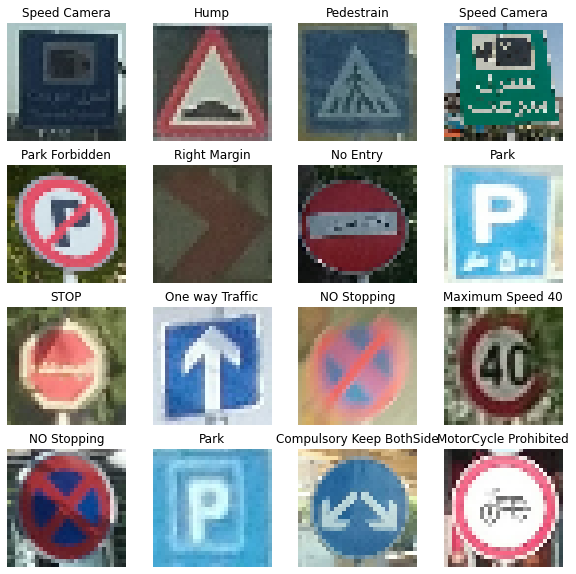

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[int(labels[i])])
        plt.axis("off")

# Model definition

In [7]:
def make_model():
    inputs = tf.keras.Input(shape=(30,30,3), name="input")

    # data augmentation
    x = layers.RandomRotation(0.1, name="random_rotation")(inputs)
    x = layers.RandomContrast(0.1, name="random_contrast")(x)

    # scaling
    x = layers.Rescaling(1./255, name="rescaling")(x)

    # CNN base
    pretrained_model = load_model('Pretrained_Model.h5')
    for layer in pretrained_model.layers[:-5]:
        layer.trainable = False
        x = layer(x)

    # MLP base
    x = layers.Flatten(name="flatten")(x)
    x = layers.Dense(512, activation='relu', name="dense")(x)
    x = layers.Dense(64, activation='relu', name="dense_1")(x)
    x = layers.BatchNormalization(name = 'batch_normalization_2')(x)
    x = layers.Dropout(rate = 0.5, name="dropout")(x)
    outputs = layers.Dense(43, activation='softmax', name="dense_2")(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Early training

In [8]:
ptsr_model = make_model()

for layer in ptsr_model.layers:
    print(f"{layer.name}:{layer.trainable}")
    
ptsr_model.summary()

input:True
random_rotation:True
random_contrast:True
rescaling:True
conv2d:False
conv2d_1:False
max_pooling2d:False
batch_normalization:False
conv2d_2:False
conv2d_3:False
max_pooling2d_1:False
batch_normalization_1:False
flatten:True
dense:True
dense_1:True
batch_normalization_2:True
dropout:True
dense_2:True
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30, 30, 3)]       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 30, 30, 3)         0         
_________________________________________________________________
random_contrast (RandomContr (None, 30, 30, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 30, 30, 3)         0         
_________________________________________________________________
conv2d (Conv2

In [9]:
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir="./tblog/early",
    update_freq="epoch",
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="./ckpt/early/{epoch:02d}-{val_loss:.2f}",
    save_weights_only=True,
)

callbacks = [
    tensorboard,
    checkpoint,
]

In [10]:
epochs = 5
optimizer = keras.optimizers.Adam(learning_rate = 0.001, decay = 0.001 / (epochs * 0.5))
loss = tf.keras.losses.SparseCategoricalCrossentropy()
ptsr_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
ptsr_model.fit(
    train_ds,
    batch_size=batch_size,
    epochs = epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

# Mid training

In [11]:
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir="./tblog/mid",
    update_freq="epoch",
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="./ckpt/mid/{epoch:02d}-{val_loss:.2f}",
    save_weights_only=True,
)

callbacks = [
    tensorboard,
    checkpoint,
]

In [12]:
ptsr_model = make_model()

for layer in ptsr_model.layers:
    layer.trainable = True
    print(f"{layer.name}:{layer.trainable}")
    
ptsr_model.summary()

input:True
random_rotation:True
random_contrast:True
rescaling:True
conv2d:True
conv2d_1:True
max_pooling2d:True
batch_normalization:True
conv2d_2:True
conv2d_3:True
max_pooling2d_1:True
batch_normalization_1:True
flatten:True
dense:True
dense_1:True
batch_normalization_2:True
dropout:True
dense_2:True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30, 30, 3)]       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 30, 30, 3)         0         
_________________________________________________________________
random_contrast (RandomContr (None, 30, 30, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 30, 30, 3)         0         
_________________________________________________________________
conv2d (Conv2D)    

In [13]:
ptsr_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
ptsr_model.load_weights("./ckpt/early/05-0.12")

In [14]:
optimizer = keras.optimizers.Adam(learning_rate = 0.001, decay = 0.001 / (epochs * 0.5))
loss = tf.keras.losses.SparseCategoricalCrossentropy()
ptsr_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
epochs = 40
ptsr_model.fit(
    train_ds,
    batch_size=batch_size,
    epochs = epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

# Final training

In [15]:
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir="./tblog/final",
    update_freq="epoch",
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="./ckpt/final/{epoch:02d}-{val_loss:.2f}",
    save_weights_only=True,
)

callbacks = [
    tensorboard,
    checkpoint,
]

In [16]:
ptsr_model = make_model()
for layer in ptsr_model.layers:
    layer.trainable = True
    print(f"{layer.name}:{layer.trainable}")
    
ptsr_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
ptsr_model.load_weights("./ckpt/mid/40-0.06")

input:True
random_rotation:True
random_contrast:True
rescaling:True
conv2d:True
conv2d_1:True
max_pooling2d:True
batch_normalization:True
conv2d_2:True
conv2d_3:True
max_pooling2d_1:True
batch_normalization_1:True
flatten:True
dense:True
dense_1:True
batch_normalization_2:True
dropout:True
dense_2:True


In [17]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0001, decay = 0.001 / (epochs * 0.5))
loss = tf.keras.losses.SparseCategoricalCrossentropy()
ptsr_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
epochs = 25

ptsr_model.fit(
    train_ds,
    batch_size=batch_size,
    epochs = epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

# Model evaluation

In [18]:
test_path = os.path.join(dataset_path,'PTSD_Recognition','sep_test')

In [19]:
test_ds = image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(30, 30),
    seed=42,
    )

Found 2421 files belonging to 43 classes.


In [20]:
ptsr_model.load_weights("./ckpt/final/25-0.07")

In [21]:
ptsr_model.evaluate(test_ds)

38/38 [==============================] - 27s 462ms/step - loss: 0.0660 - accuracy: 0.9851


[0.06596482545137405, 0.9851301312446594]

## confusion matrix

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

In [23]:
predictions = []
true_labels = []
for images, labels in test_ds:
    predict = ptsr_model.predict(images) 
    predict = np.argmax(predict,axis=1)
    predictions.extend(predict)
    true_labels.extend(labels.numpy())

In [24]:
cr= classification_report(true_labels, predictions, digits=4)
print(cr)

              precision    recall  f1-score   support

           0     0.9828    0.9828    0.9828        58
           1     1.0000    1.0000    1.0000        85
           2     0.9921    1.0000    0.9960       125
           3     0.9833    0.9672    0.9752        61
           4     0.9855    0.9855    0.9855        69
           5     0.9890    1.0000    0.9945        90
           6     1.0000    0.9873    0.9936        79
           7     1.0000    1.0000    1.0000        20
           8     0.9863    1.0000    0.9931        72
           9     0.9762    1.0000    0.9880        41
          10     0.9863    0.9730    0.9796        74
          11     0.9667    0.9355    0.9508        31
          12     0.9753    1.0000    0.9875        79
          13     0.8824    0.8571    0.8696        35
          14     1.0000    0.9375    0.9677        16
          15     0.6316    0.9231    0.7500        13
          16     1.0000    0.7647    0.8667        17
          17     1.0000    

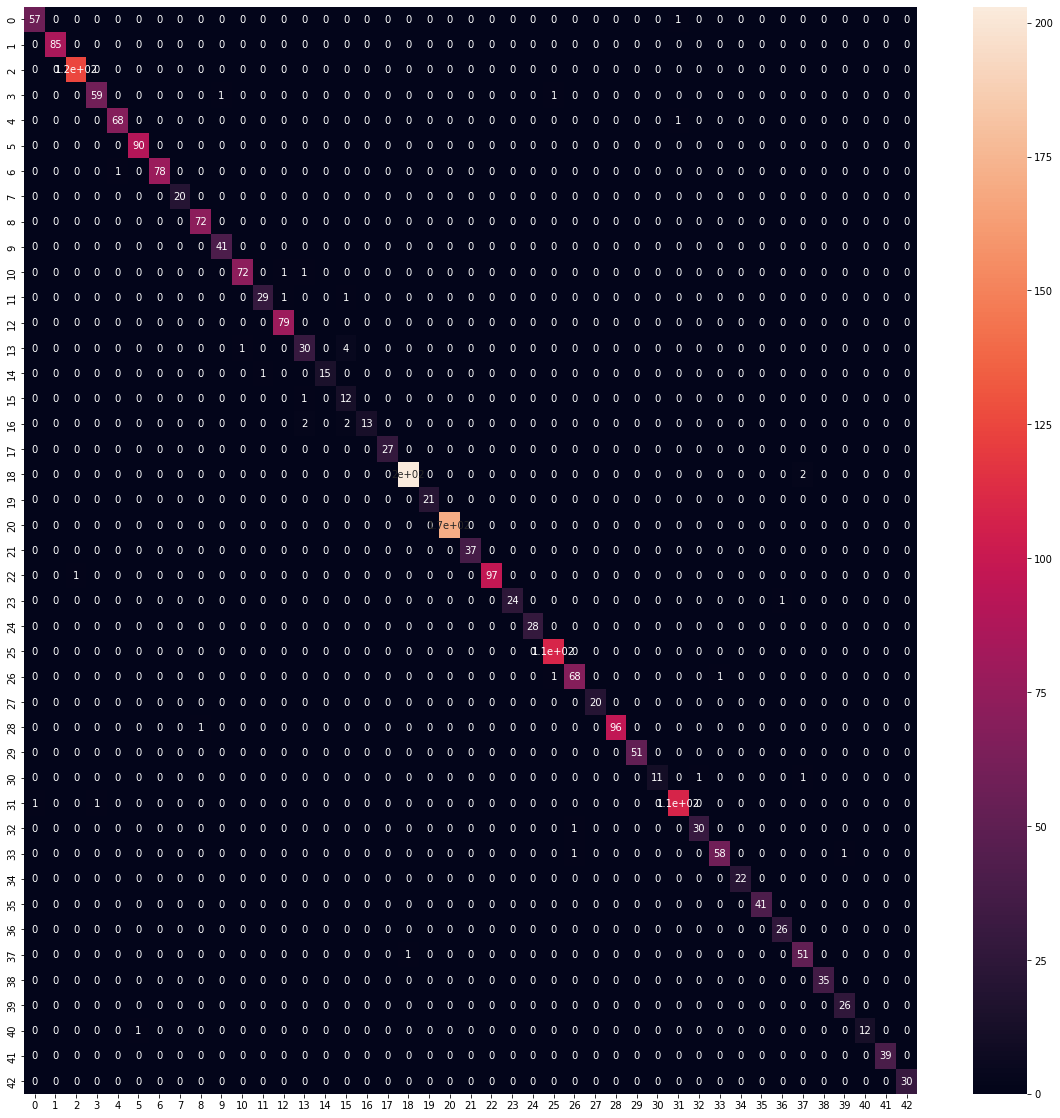

In [25]:
cf = confusion_matrix(true_labels, predictions)
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True);

### ***Mohammad gorji***